# Tratamiento de Latitud y Longitud en el Dataset de Precios de Viviendas de California

## Carga y preparación de los datos

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

housing = pd.read_csv("./data/housing.csv") 
train_set, test_set = train_test_split(housing, test_size=0.2,
    stratify=pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5]),
    random_state=42
    )

housing = train_set.drop("median_house_value", axis=1) # Eliminamos la columna de la variable dependiente
housing_labels = train_set["median_house_value"].copy() # Guardamos la variable dependiente (etiquetas)

## Comprensión de las coordenadas geográficas en el *dataset*

Las coordenadas geográficas representan una característica especial en este dataset ya que la ubicación es fundamental para determinar el precio. Sin embargo, las coordenadas geográficas no son una característica directamente interpretable por los modelos de aprendizaje automático, ya que no es que al aumentar la latitud o la longitud el precio de la vivienda aumente o disminuya.

Las coordenadas geográficas nos permiten:
- Identificar patrones espaciales en los precios de viviendas
- Crear características derivadas que capturen la "proximidad" a lugares de interés
- Agrupar distritos por regiones geográficas similares

## K-means para agrupamiento geográfico


K-means es un algoritmo de *clustering* (aprendizaje no supervisado) con el que podríamos agrupar los distritos en regiones geográficas similares. Para ello, utilizaremos las coordenadas geográficas de los distritos y agruparemos los distritos en un número fijo de regiones geográficas.

In [48]:
from sklearn.cluster import KMeans

# Aplicar K-means con k=6 (por ejemplo, para dividir California en 6 regiones)
kmeans = KMeans(n_clusters=6, random_state=42)
housing['region_cluster'] = kmeans.fit_predict(housing[['latitude', 'longitude']])
housing[['latitude', 'longitude', 'region_cluster']].head()

,latitude,longitude,region_cluster
12655,38.52,-121.46,3
15502,33.09,-117.23,4
2908,35.37,-119.04,5
14053,32.75,-117.13,4
20496,34.28,-118.70,0


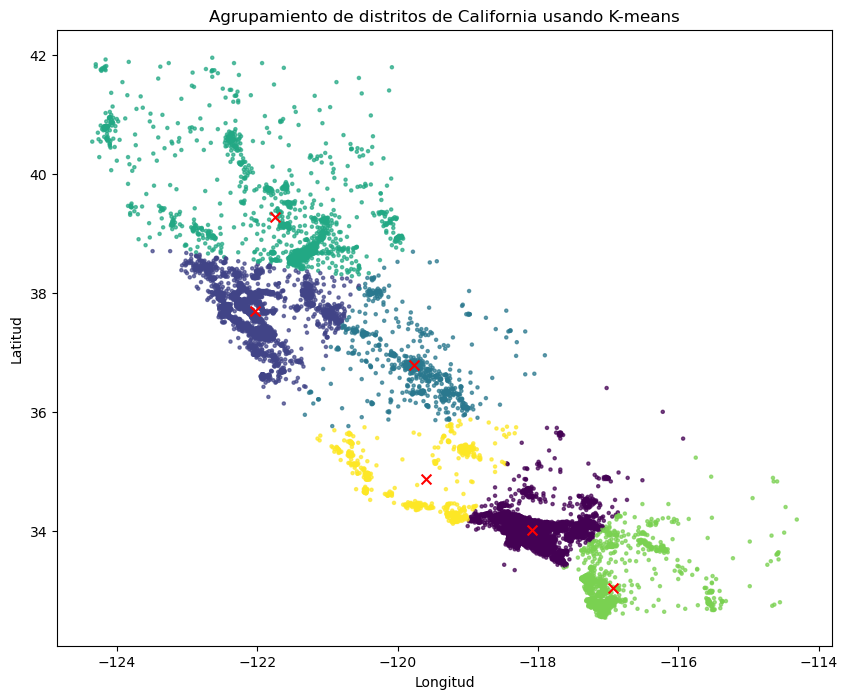

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(housing['longitude'], housing['latitude'], 
            c=housing['region_cluster'], cmap='viridis', 
            s=5, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], 
            c='red', s=50, marker='x')
plt.title('Agrupamiento de distritos de California usando K-means')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

Podríamos crear un transformador personalizado para ese proceso:

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

class RegionClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=6, random_state=42):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=random_state)
    
    def fit(self, X, y=None):
        """
        Ajusta el modelo KMeans usando las columnas 'latitude' y 'longitude'.
        Se asume que X es un DataFrame de pandas que contiene estas columnas.
        """
        self.kmeans.fit(X[['latitude', 'longitude']])
        return self
    
    def transform(self, X):
        """
        Transforma el DataFrame X agregando la columna 'region_cluster' que contiene
        la predicción del clúster para cada registro.
        """
        X_transformed = X.copy()
        X_transformed['region_cluster'] = self.kmeans.predict(X_transformed[['latitude', 'longitude']])
        return X_transformed

In [51]:
transformer = RegionClusterTransformer(n_clusters=6, random_state=42)
transformer.fit(housing)
housing_transformed = transformer.transform(housing)
housing_transformed[['latitude', 'longitude', 'region_cluster']].head()

,latitude,longitude,region_cluster
12655,38.52,-121.46,3
15502,33.09,-117.23,4
2908,35.37,-119.04,5
14053,32.75,-117.13,4
20496,34.28,-118.70,0


## Añadiendo la distancia a los centroides como característica

Sin embargo, los precios de las viviendas no solo se relacionan por el cluster de distritos en que se encuentran, sino que es probable que aquellos distritos más cerca del centro del cluster tengan precios más altos. Por lo tanto, sería útil crear una característica que capture la "proximidad" a los centros de los clusters.

In [52]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

class DistanceClusterTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador personalizado para agrupar ubicaciones geográficas usando K-means.
    Espera un DataFrame con al menos dos columnas: 'latitude' y 'longitude'.
    """
    def __init__(self, n_clusters=8, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.kmeans_ = None

    def fit(self, X, y=None):
        # Se espera que X sea un DataFrame o array con columnas 'latitude' y 'longitude'
        # Convertimos a array en caso de ser DataFrame:
        if isinstance(X, pd.DataFrame):
            coords = X[['latitude', 'longitude']].values
        else:
            coords = X[:, :2]  # asumiendo que las dos primeras columnas son lat/lon
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(coords)
        return self

    def transform(self, X):
        # Aseguramos que X es un DataFrame para facilitar el manejo de columnas
        X_trans = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=['latitude', 'longitude'])
        coords = X_trans[['latitude', 'longitude']].values
        
        # Predecimos la etiqueta de cluster
        cluster_labels = self.kmeans_.predict(coords)
        X_trans['geo_cluster'] = cluster_labels
        
        # Calculamos la distancia de cada punto al centroide asignado
        distances = []
        for i, point in enumerate(coords):
            centroid = self.kmeans_.cluster_centers_[cluster_labels[i]]
            distance = np.linalg.norm(point - centroid)
            distances.append(distance)
        X_trans['distance_to_centroid'] = distances
        
        return X_trans


In [53]:
geoClusterTransformer = DistanceClusterTransformer(n_clusters=5)
geoClusterTransformer.fit(housing[['longitude', 'latitude']])
housing_geo_clusters = geoClusterTransformer.transform(housing[['longitude', 'latitude']])
housing_geo_clusters.head()

,longitude,latitude,geo_cluster,distance_to_centroid
12655,-121.46,38.52,3,0.810514
15502,-117.23,33.09,4,0.287789
2908,-119.04,35.37,2,0.995066
14053,-117.13,32.75,4,0.361414
20496,-118.70,34.28,0,0.614293


## Similitud con rbg_kernel

### rbf_kernel

La función `rbf_kernel` calcula la similitud entre dos conjuntos de datos a través de la *radial basis function* (RBF), devolviendo un valor entre 0 y 1.
Por ejemplo, si asumiésemos que los inmuebles de alrededor de 35 años incrementan su valor por alguna particularidad, podríamos medir la distancia de cada uno a los de 35 años y asignarle un valor de similitud.

In [54]:
from sklearn.metrics.pairwise import rbf_kernel
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

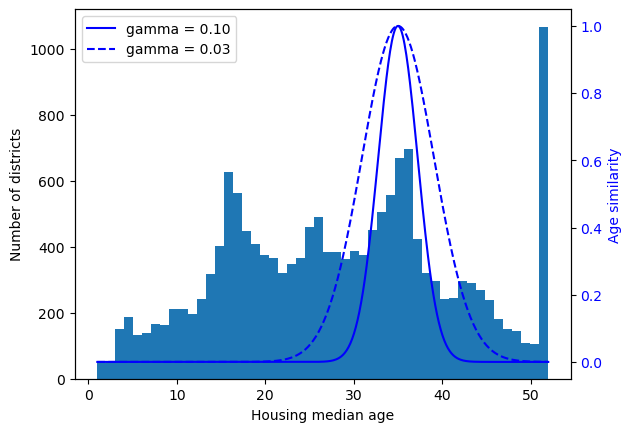

In [55]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
plt.show()

Podemos ver cómo el valor `gamma` permite ajustar la similitud entre los datos, abriendo más o menos la función RBF, que es una normal (gaussiana) centrada en el valor de referencia. A la derecha podemos ver la escala entre 0 y 1 de similitud que devolverán los registros cercanos al valor de referencia.

### Midiendo similitud a centroides con rbf_kernel

En lugar de la distancia, podemos utilizar rbf_kernel para medir la proximidad de cada distrito a los centros de los clusters.

In [56]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [57]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

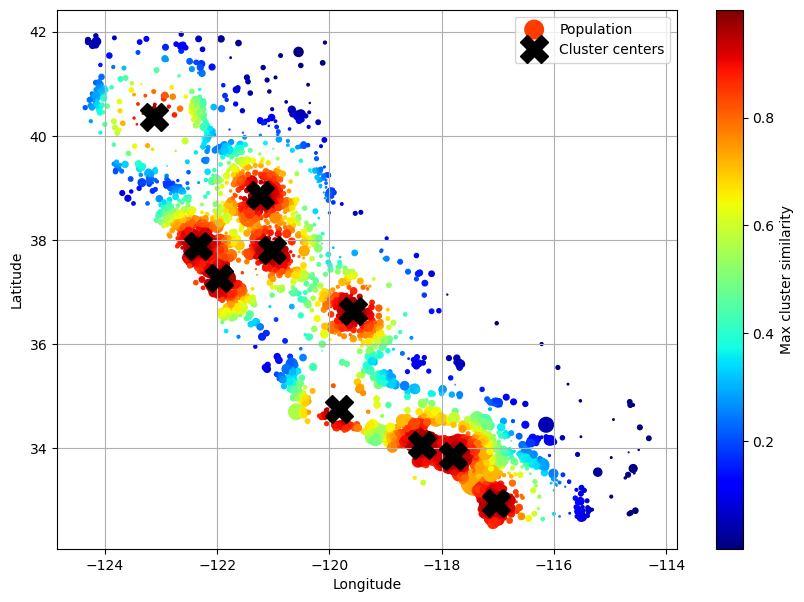

In [58]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()